In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam

## Visualizing single audio file

In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/music_genre_classification/genres_original"  # Adjust path if needed
os.listdir(data_path)

['metal',
 'country',
 'hiphop',
 'disco',
 'rock',
 'jazz',
 'pop',
 'reggae',
 'classical',
 'blues']

In [ ]:
audio_file = "/content/drive/My Drive/music_genre_classification/genres_original/blues/blues.00000.wav"

In [ ]:
y,sr = librosa.load(audio_file,sr=44100)

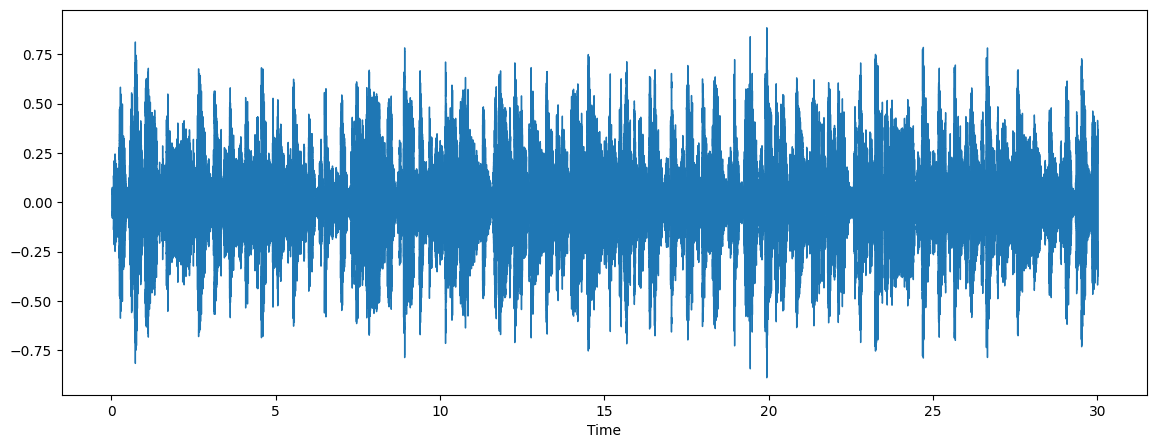

In [ ]:
plt.figure(figsize=(14,5))
librosa.display.waveshow(y,sr=sr)

## visualization on subparts of audio file

In [ ]:
audio_path = "./blues.00000.wav"

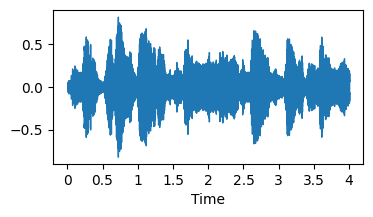

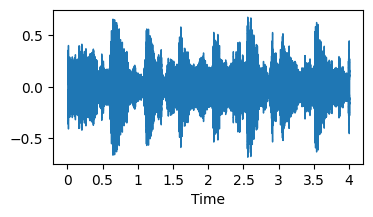

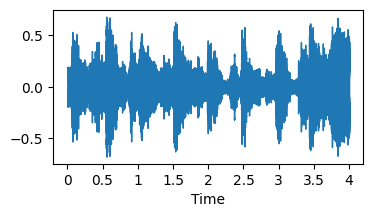

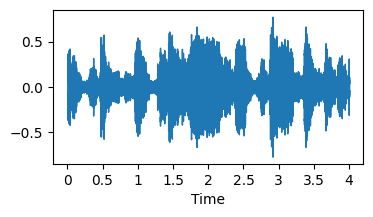

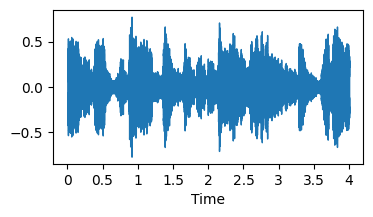

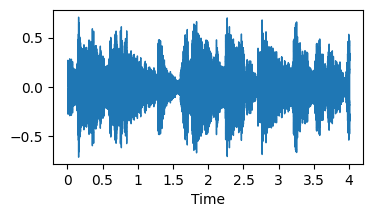

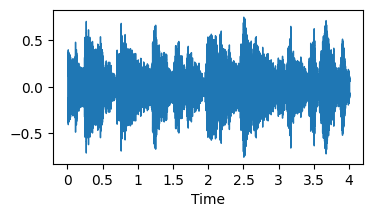

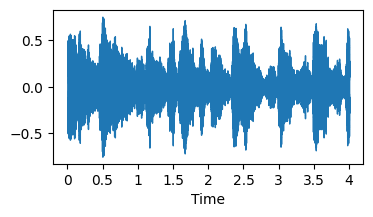

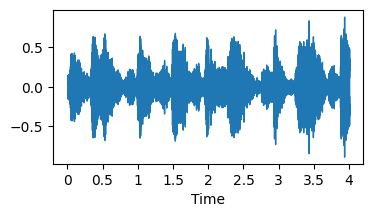

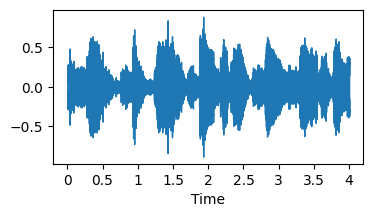

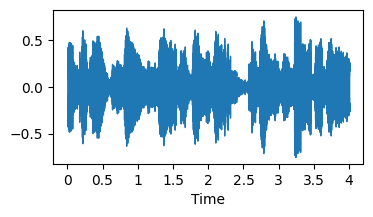

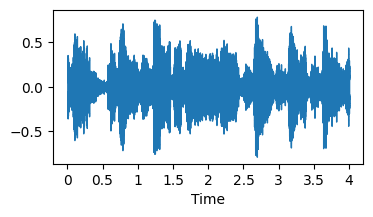

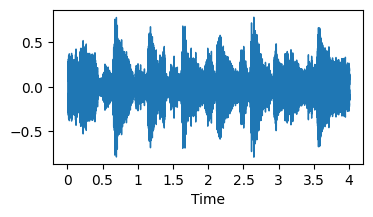

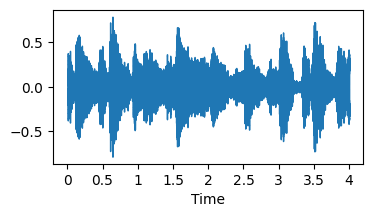

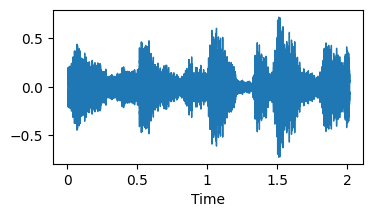

In [ ]:
y,sr = librosa.load(audio_file,sr=None)

duration = 4
overlap_duration = 2

samples = duration*sr
overlap_sample = overlap_duration*sr

tot_samples = int(np.ceil((len(y)-samples)/(samples-overlap_sample)))+1

for i in range(tot_samples):
    start = i*(samples-overlap_sample)
    end = start+samples
    chunk = y[start:end]
    plt.figure(figsize=(4,2))
    librosa.display.waveshow(chunk,sr=sr)
    plt.show()




## Melspectrogram visualization

In [ ]:
def plot_melspectrogram(y,sr):
    spectorgram = librosa.feature.melspectrogram(y=y,sr=sr)
    spectrogram_db = librosa.power_to_db(spectorgram,ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title('spectrogram')
    plt.tight_layout()
    plt.show()



In [ ]:
y,sr = librosa.load(audio_file,sr=44100)

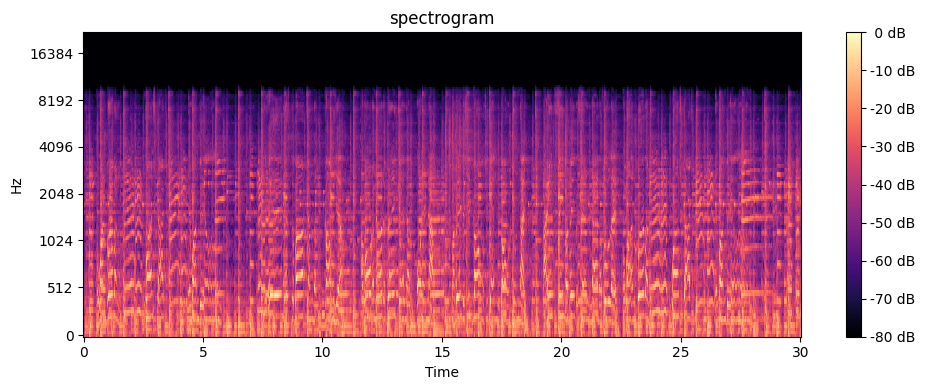

In [ ]:
plot_melspectrogram(y,sr)

In [ ]:
def plot_melspectrogram_sample(y,sr):
    duration = 4
    overlap_duration = 2

    samples = duration*sr
    overlap_sample = overlap_duration*sr

    tot_samples = int(np.ceil((len(y)-samples)/(samples-overlap_sample)))+1

    for i in range(tot_samples):
        start = i*(samples-overlap_sample)
        end = start+samples
        chunk = y[start:end]
        spectorgram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        spectrogram_db = librosa.power_to_db(spectorgram,ref=np.max)
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title('spectrogram')
        plt.tight_layout()
        plt.show()



In [ ]:
y,sr = librosa.load(audio_file,sr=44100)

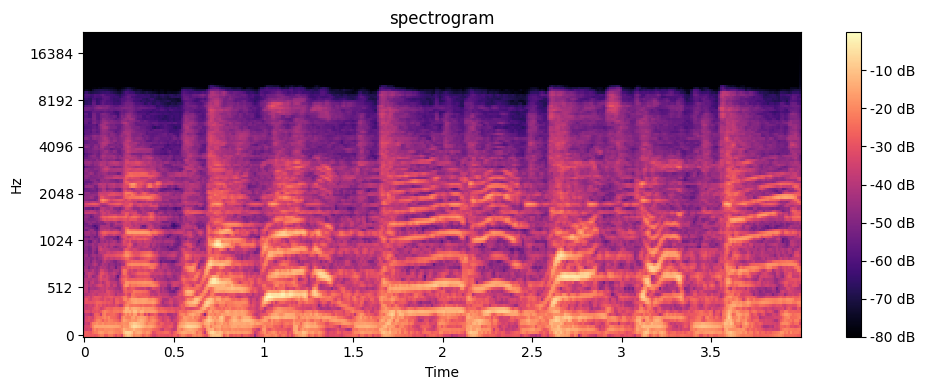

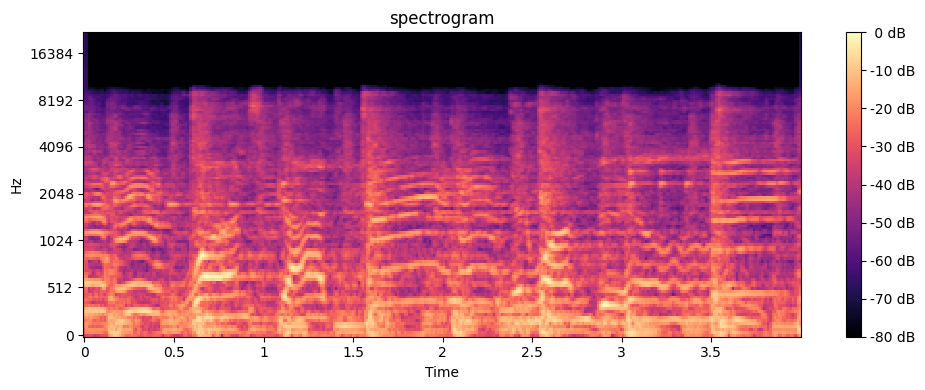

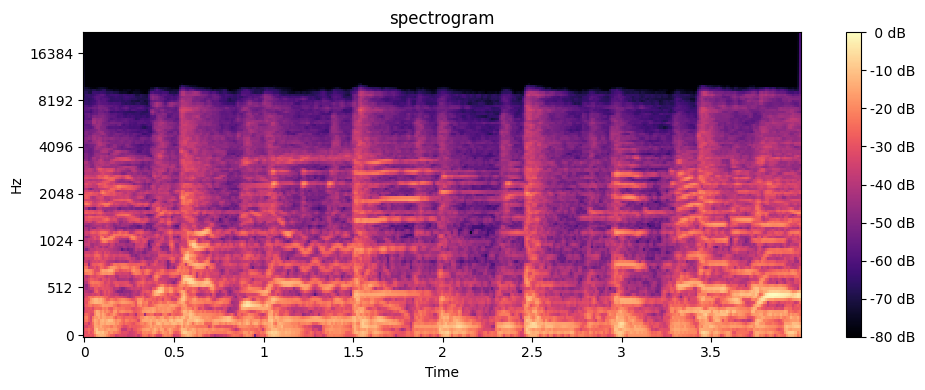

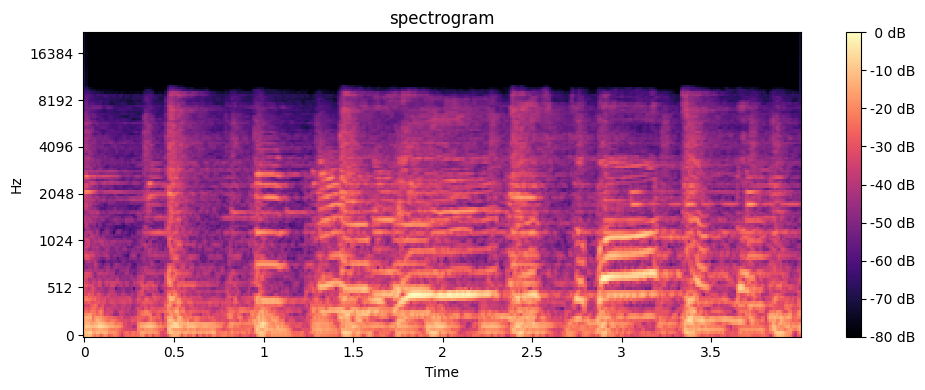

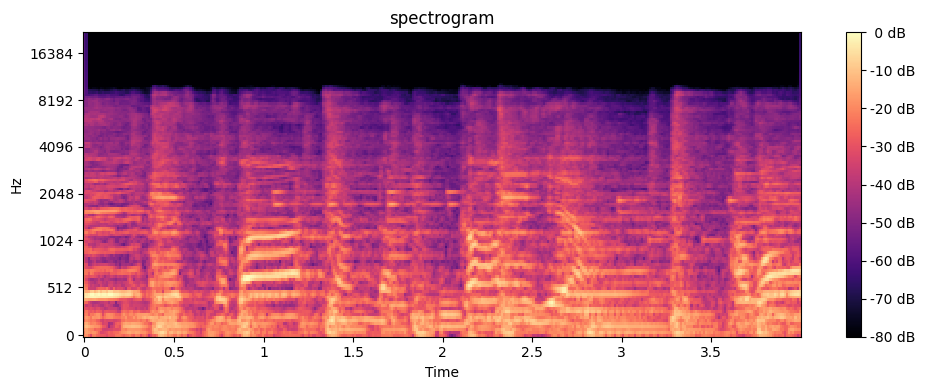

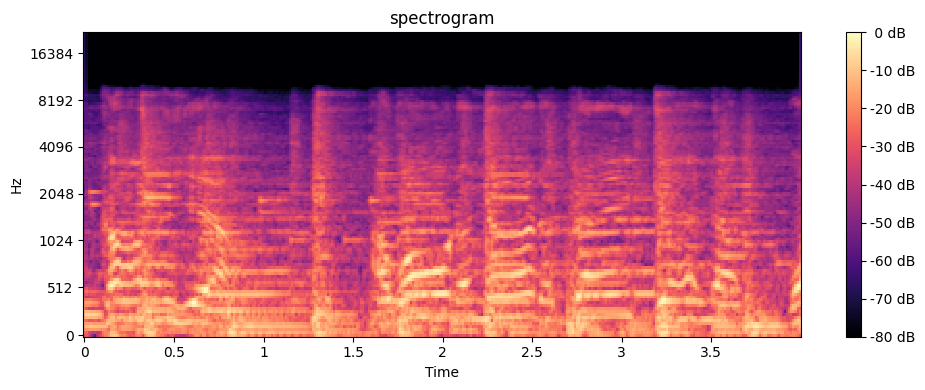

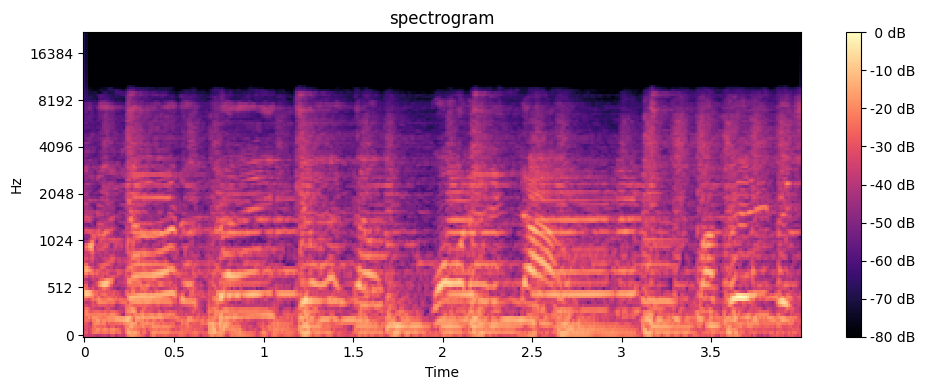

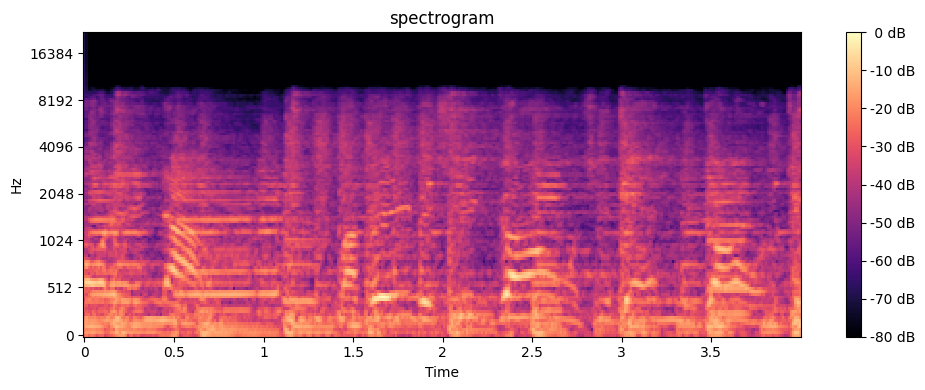

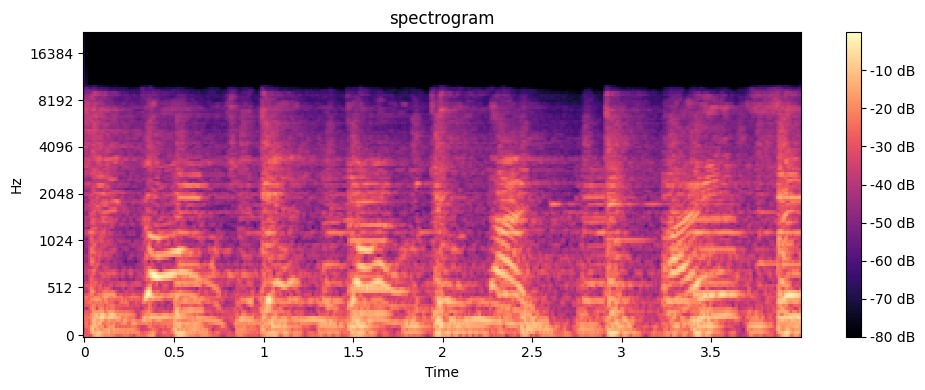

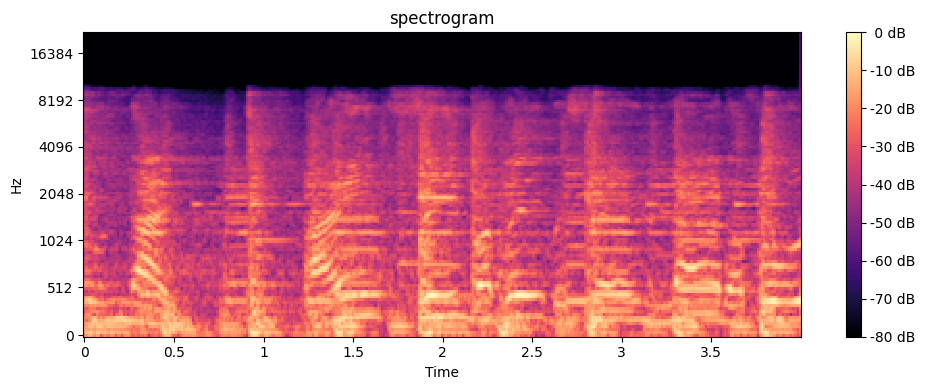

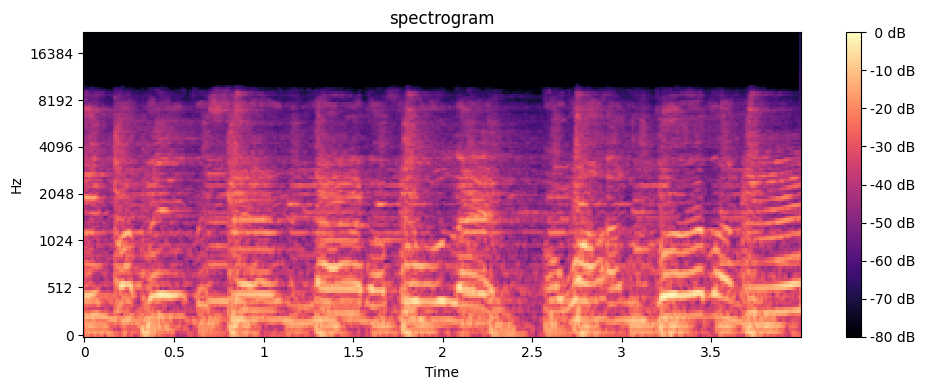

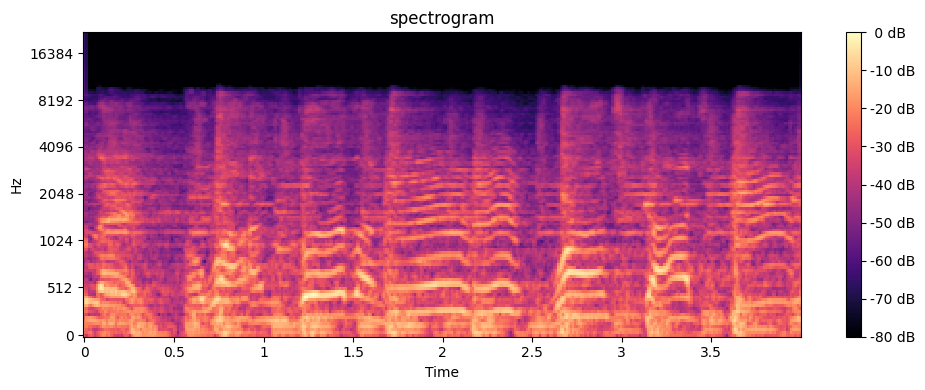

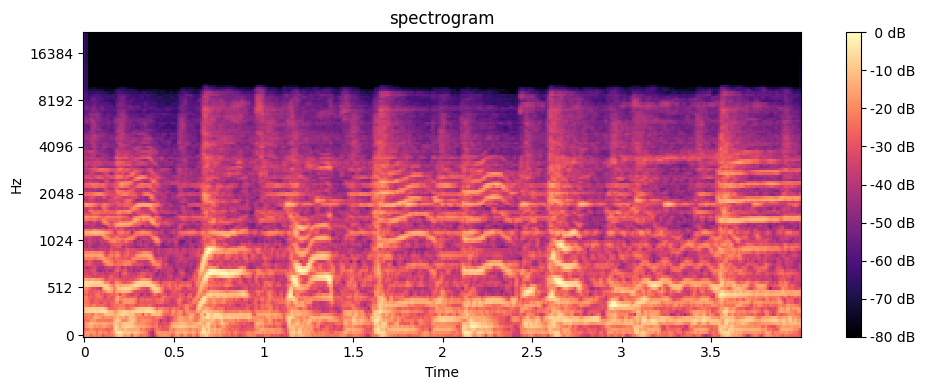

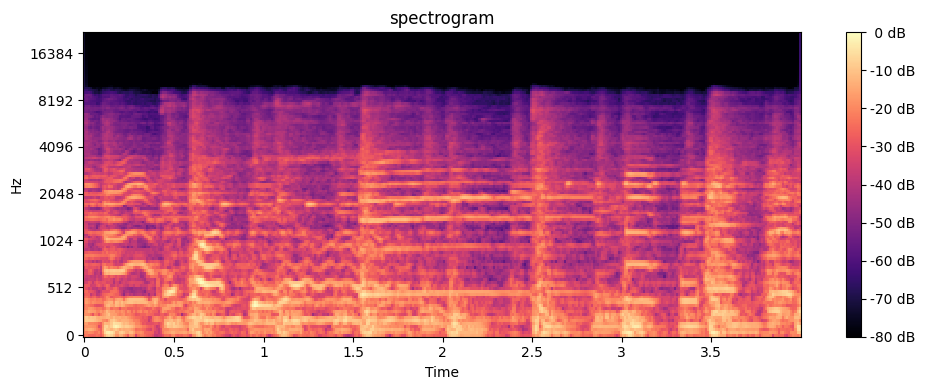

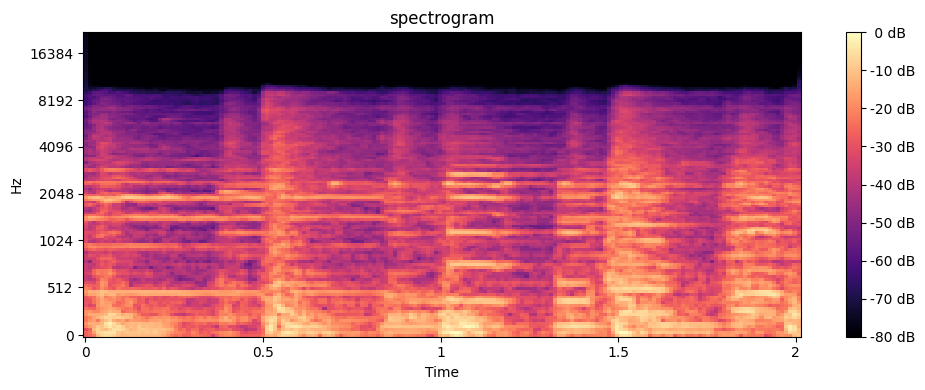

In [ ]:
plot_melspectrogram_sample(y,sr)

## Data Preprocessing

In [3]:
data_dir = "/content/drive/My Drive/music_genre_classification/genres_original"
classes = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [4]:

from skimage.transform import resize

def preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("directory--", class_name)

        for file_name in os.listdir(class_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_dir, file_name)
                audio_data, sr = librosa.load(file_path, sr=None)
                duration = 4
                overlap_duration = 2

                samples = duration * sr
                overlap_sample = overlap_duration * sr

                total_samples = max(1, int(np.ceil((len(audio_data) - samples) / (samples - overlap_sample))) + 1)

                for i in range(total_samples):
                    start = i * (samples - overlap_sample)
                    end = start + samples
                    chunk = audio_data[start:end]

                    # Ignore segments that are too short
                    if len(chunk) < 512:
                        continue

                    # Dynamically adjust n_fft to avoid warnings
                    n_fft = min(2048, len(chunk) // 2)

                    spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr, n_fft=n_fft)
                    spectrogram = resize(np.expand_dims(spectrogram, axis=-1), target_shape)

                    data.append(spectrogram)
                    labels.append(i_class)

    return np.array(data), np.array(labels)


In [5]:
data,labels = preprocess_data(data_dir,classes)
print("done")

directory-- blues
directory-- classical
directory-- country
directory-- disco
directory-- hiphop
directory-- jazz
directory-- metal
directory-- pop
directory-- reggae
directory-- rock
done


In [6]:
data.shape, labels.shape

((14975, 128, 128, 1), (14975,))

In [7]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes))

In [8]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
labels.shape

(14975, 10)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)


In [11]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((11980, 128, 128, 1), (2995, 128, 128, 1), (11980, 10), (2995, 10))

In [12]:
model = tf.keras.models.Sequential()

In [13]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=x_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Dropout(0.3))

model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

model.add(Dropout(0.3))



model.add(Flatten())

model.add(Dense(units=1200,activation='relu'))

model.add(Dropout(0.4))

model.add(Dense(units=len(classes),activation='softmax'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
train_hist = model.fit(x_train,y_train,epochs=30,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 84ms/step - accuracy: 0.2072 - loss: 2.1639 - val_accuracy: 0.4464 - val_loss: 1.5418
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.4666 - loss: 1.5015 - val_accuracy: 0.5359 - val_loss: 1.3088
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.5888 - loss: 1.1926 - val_accuracy: 0.6634 - val_loss: 0.9607
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.6518 - loss: 0.9984 - val_accuracy: 0.7152 - val_loss: 0.8416
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.7209 - loss: 0.8246 - val_accuracy: 0.7342 - val_loss: 0.7791
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.7676 - loss: 0.6895 - val_accuracy: 0.8083 - val_loss: 0.5887
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.7906 - loss: 0.6103 - val_accuracy: 0.7937 - val_loss: 0.6186
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8414 - loss: 0.4676 - 

In [17]:
model.save("/content/drive/My Drive/music_genre_classification/train_model.keras")

In [18]:
train_hist

In [19]:
import json

history_path = "/content/drive/My Drive/music_genre_classification/train_history.json"

# Convert history to JSON format
with open(history_path, "w") as f:
    json.dump(train_hist.history, f)


In [20]:
os.listdir("/content/drive/My Drive/music_genre_classification/")

['requirement.txt',
 'test.py',
 'blues.00000.wav',
 '.ipynb_checkpoints',
 'genres_original',
 'train_music_genre_classifier.ipynb',
 'train_model.keras',
 'train_history.json']

In [21]:

model = tf.keras.models.load_model("/content/drive/My Drive/music_genre_classification/train_model.keras")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 21,547,376 (82.20 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,364,918 (54.80 MB)

In [22]:
import json
with open("/content/drive/My Drive/music_genre_classification/train_history.json",'r') as json_file:
  training_hist = json.load(json_file)


In [23]:
training_hist.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
train_loss,train_acc = model.evaluate(x_train,y_train)

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9886 - loss: 0.0378


In [25]:
train_loss,train_acc

(0.03579816594719887, 0.9888147115707397)

In [26]:
val_loss,val_acc = model.evaluate(x_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9117 - loss: 0.3456


In [27]:
val_loss,val_acc

(0.38989898562431335, 0.9068447351455688)

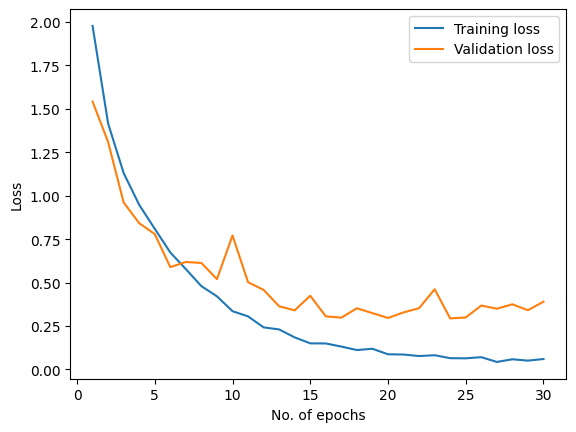

In [28]:
epochs = [i for i in range(1,31)]

plt.plot(epochs,training_hist['loss'],label="Training loss")
plt.plot(epochs,training_hist['val_loss'],label="Validation loss")
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

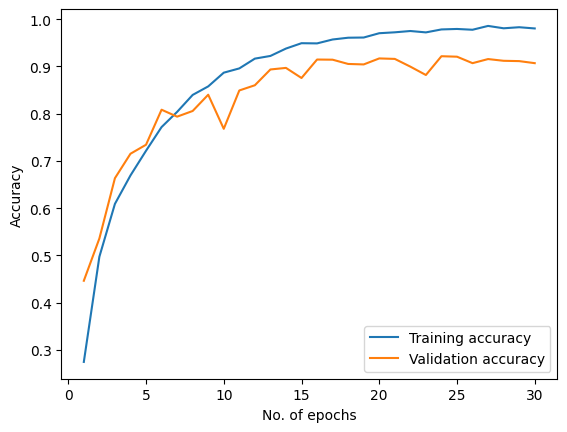

In [29]:
epochs = [i for i in range(1,31)]

plt.plot(epochs,training_hist['accuracy'],label="Training accuracy")
plt.plot(epochs,training_hist['val_accuracy'],label="Validation accuracy")
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [30]:
y_pred = model.predict(x_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [31]:
y_pred.shape

(2995, 10)

In [32]:
pred_cat = np.argmax(y_pred,axis=1)
len(pred_cat)

2995

In [33]:
from sklearn.metrics import confusion_matrix,classification_report

In [34]:
y_test.shape

(2995, 10)

In [35]:
true_cat = np.argmax(y_test,axis=1)

In [36]:
len(true_cat)

2995

In [38]:
cm = confusion_matrix(true_cat,pred_cat)
print(classification_report(true_cat,pred_cat,target_names=classes))

              precision    recall  f1-score   support

       blues       0.88      0.93      0.90       300
   classical       0.96      0.97      0.97       300
     country       0.76      0.91      0.83       299
       disco       0.95      0.91      0.93       300
      hiphop       0.96      0.91      0.94       300
        jazz       0.86      0.97      0.91       297
       metal       0.97      0.91      0.94       300
         pop       0.94      0.92      0.93       300
      reggae       0.89      0.92      0.90       300
        rock       0.95      0.71      0.81       299

    accuracy                           0.91      2995
   macro avg       0.91      0.91      0.91      2995
weighted avg       0.91      0.91      0.91      2995



In [39]:
cm

array([[279,   4,   4,   0,   0,  10,   1,   0,   2,   0],
       [  0, 292,   0,   0,   0,   8,   0,   0,   0,   0],
       [  7,   0, 272,   1,   0,  15,   0,   1,   2,   1],
       [  3,   0,   4, 274,   4,   1,   0,   6,   7,   1],
       [  5,   0,   1,   4, 274,   0,   2,   3,  11,   0],
       [  2,   3,   4,   0,   0, 288,   0,   0,   0,   0],
       [  3,   0,  11,   0,   0,   1, 273,   2,   0,  10],
       [  5,   1,   6,   2,   3,   2,   0, 276,   5,   0],
       [  7,   1,   6,   2,   2,   3,   0,   3, 276,   0],
       [  7,   3,  49,   4,   1,   7,   4,   4,   8, 212]])

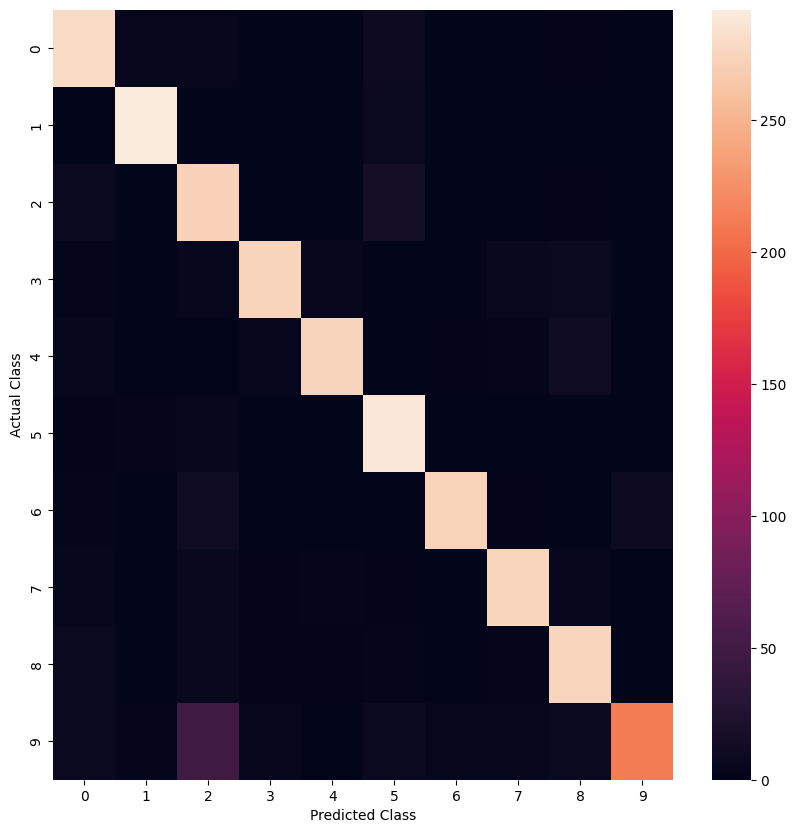

In [43]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()